# Modeling the Fire Data for Fires Over 1 Acre and Lasting Longer than 24 Hours

## Focusing on Removing Outliers and Polynomial Features

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ridge_regression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

In [2]:
df = pd.read_csv('../../data/cleaned/final_all.csv')

df.head()

,id,dailyacres,discoveryacres,temp_2m,temp_2m_max,humidity,rain,wind_speed_2m,wind_speed_2m_max,wind_speed_10m,...,rain_sum,dew_frost_point_2m,wet_bulb_temp_2m,relative_humidity,clear_sky_photosynthetically_active_radiation,all_sky_photosynthetically_active_radiation,all_sky_surface_uv_index,sum_rain,sum_snow,land_cover_class
0,1,5985.90,5.0,24.80,33.19,5.92,0.00,1.76,3.42,2.61,...,12.62,3.02,13.91,27.31,155.74,135.50,2.55,84.37,1.32,489
1,5,135.00,1.0,22.72,31.95,2.69,0.00,2.65,4.88,3.88,...,0.00,-6.50,8.11,13.62,97.43,97.50,1.37,10.54,0.00,470
2,10,132.00,15.0,26.21,35.48,7.57,0.01,1.62,4.30,2.66,...,0.16,7.16,16.69,33.44,160.50,160.38,2.82,68.55,0.66,183
3,12,1.88,1.0,-0.55,3.97,2.14,0.00,0.06,0.10,5.79,...,0.00,-9.35,-4.95,51.38,59.11,57.91,0.37,700.02,14.17,163
4,15,13.00,0.1,22.30,32.40,8.00,0.00,0.16,0.45,1.83,...,1.61,8.76,15.53,48.62,142.94,114.08,1.96,295.31,0.66,301


In [3]:
df.shape

(2053, 29)

In [4]:
df['dailyacres'].describe()

count      2053.000000
mean       3006.494831
std       21542.951913
min           1.030000
25%           3.500000
50%          16.750000
75%         155.000000
max      413717.000000
Name: dailyacres, dtype: float64

In [5]:
iqr = 155.0-3.2
upper_range = 1.5*iqr + 155.0
df = df[df['dailyacres'] <= upper_range]

In [6]:
df.shape

(1667, 29)

In [7]:
2053-1667

386

---
######
### Investigating Correlation Between the Features and Target (DailyAcres)
######
___

In [8]:
cols = ['dailyacres', 'discoveryacres', 'temp_2m', 'temp_2m_max', 'humidity', 'rain', 'wind_speed_2m', 'wind_speed_2m_max', 'wind_speed_10m', 
        'wind_speed_10m_max', 'surface_soil_wetness_5cm_below', 'surface_soil_wetness_to_bedrock', 'wind_speed_2m_mean', 'wind_speed_2m_max_mean', 
        'wind_speed_10m_mean', 'wind_speed_10m_max_mean', 'humidity_mean', 'temp_2m_mean', 'rain_sum', 'dew_frost_point_2m', 'wet_bulb_temp_2m', 
        'relative_humidity', 'clear_sky_photosynthetically_active_radiation', 'all_sky_photosynthetically_active_radiation', 'all_sky_surface_uv_index',
        'sum_rain', 'sum_snow','land_cover_class']

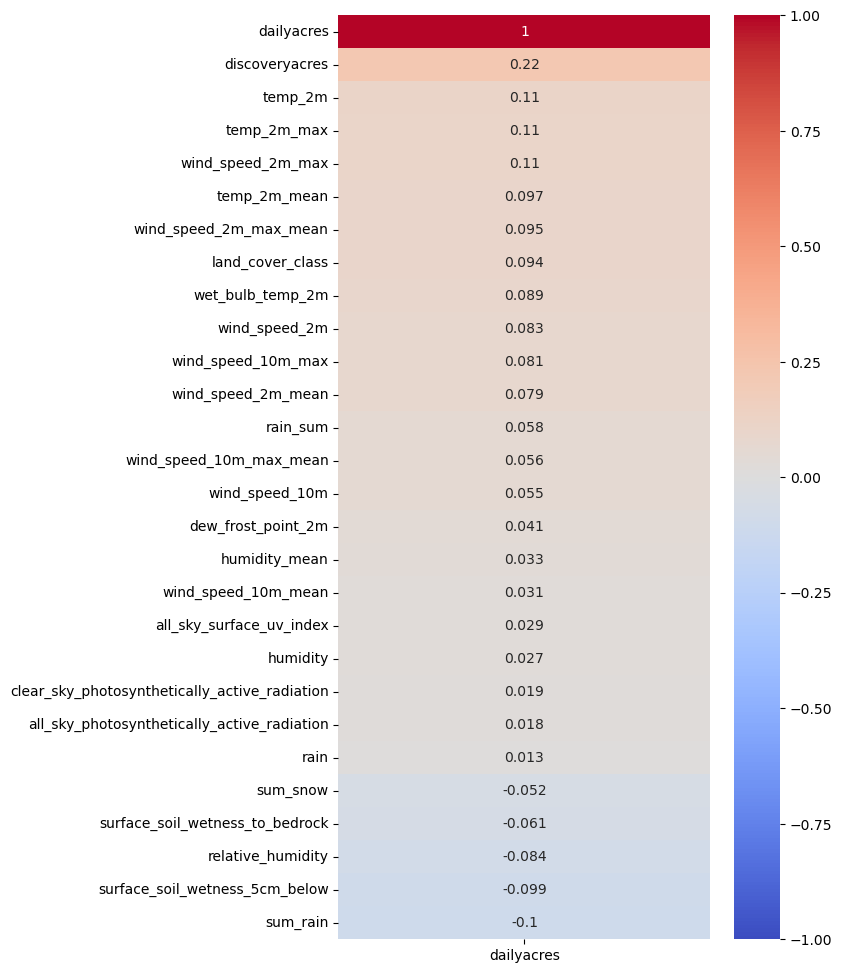

In [9]:
plt.figure(figsize = (6, 12))
sns.heatmap(df[cols].corr()[['dailyacres']].sort_values(by = 'dailyacres', ascending=False),
            vmin = -1,
            vmax = 1, 
            cmap = 'coolwarm',
            annot = True);

---
######
### Train/Test Splitting Data, and Standard Scaling
######
___

In [10]:
df = df[cols]

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'dailyacres'), df['dailyacres'], random_state= 42)

In [11]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

---
######
### Using PCA For Feature Elimination
######
___

In [12]:
poly = PolynomialFeatures()
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.transform(X_test)

In [43]:
poly_X_train.shape

(1250, 406)

In [13]:
pca = PCA(random_state = 42)


Z_train = pca.fit_transform(poly_X_train)
Z_test = pca.transform(poly_X_test)

In [14]:
explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)
np.round(cumulative[:50], 3)

array([0.221, 0.318, 0.4  , 0.478, 0.547, 0.612, 0.648, 0.679, 0.708,
       0.731, 0.75 , 0.767, 0.781, 0.792, 0.803, 0.813, 0.822, 0.831,
       0.84 , 0.847, 0.854, 0.861, 0.867, 0.874, 0.879, 0.885, 0.89 ,
       0.894, 0.899, 0.902, 0.906, 0.91 , 0.913, 0.916, 0.919, 0.921,
       0.924, 0.926, 0.929, 0.931, 0.933, 0.935, 0.938, 0.94 , 0.942,
       0.943, 0.945, 0.947, 0.949, 0.95 ])

In [15]:
Z_train = Z_train[:,:50]
Z_test = Z_test[:,:50]

In [42]:
#np.savetxt('../../data/processed/Neural_Net_Data/X_train_without_outliers.csv', X_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/X_test_without_outliers.csv', X_test, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_train_without_outliers.csv', Z_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_test_without_outliers.csv', Z_test, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/y_train_without_outliers.csv', y_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/y_test_without_outliers.csv', y_test, delimiter=',')

---
######
### Modeling / Simple Models
######
---

#### Linear Regression (Baseline) with DF

In [17]:
#Linear Regression - Baseline
# With X data
lr = LinearRegression()

lr.fit(X_train, y_train)
print(f'Training R-Squared: {lr.score(X_train, y_train)}')
print(f'Testing R-Squared: {lr.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(X_test), squared = False)}')

Training R-Squared: 0.09505942584980276
Testing R-Squared: 0.07268041320327412
RMSE: 58.29172509469402


#### Linear Regression (Baseline) with PCA

In [18]:
#Linear Regression - Baseline
# With PCA Data
lr = LinearRegression()

lr.fit(Z_train, y_train)
print(f'Training R-Squared: {lr.score(Z_train, y_train)}')
print(f'Testing R-Squared: {lr.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(Z_test), squared = False)}')

Training R-Squared: 0.1083392560043328
Testing R-Squared: -0.0211514247616722
RMSE: 61.16982885392083


In [19]:
def model_eval(model, param_dict, training_data):
    '''
    d
    '''
    
    gs_model = GridSearchCV(model,
                            param_grid = param_dict,
                            n_jobs = -1)
    if training_data == 'X_train':
        gs_model.fit(X_train, y_train)
        print(f'Best Score: {gs_model.best_score_}')
        print(f'Best Params: {gs_model.best_params_}')
        print('='*50)
        print(f'RMSE: {mean_squared_error(y_test, gs_model.predict(X_test), squared = False)}')
        print('='*50)
        print(f'Training R-Squared: {gs_model.score(X_train, y_train)}')
        print(f'Testing R-Squared: {gs_model.score(X_test, y_test)}')
        
    elif training_data == 'Z_train':
        gs_model.fit(Z_train, y_train)
        print(f'Best Score: {gs_model.best_score_}')
        print(f'Best Params: {gs_model.best_params_}')
        print('='*50)
        print(f'RMSE: {mean_squared_error(y_test, gs_model.predict(Z_test), squared = False)}')
        print('='*50)
        print(f'Training R-Squared: {gs_model.score(Z_train, y_train)}')
        print(f'Testing R-Squared: {gs_model.score(Z_test, y_test)}')
    else:
        return 'Try Again'

#### KNN Regression with DF

In [20]:
#KNN Regressor with X Data

knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(10, 201, 10),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'X_train')

Best Score: 0.042156825239770226
Best Params: {'n_neighbors': 50, 'weights': 'distance'}
RMSE: 59.634213447574126
Training R-Squared: 0.9999812958104124
Testing R-Squared: 0.029475266436248204


#### KNN Regression with PCA Data

In [21]:
#KNN Regressor with PCA Data

knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(10, 201, 10),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'Z_train')

Best Score: 0.03247930455518655
Best Params: {'n_neighbors': 30, 'weights': 'distance'}
RMSE: 59.86365956029956
Training R-Squared: 0.9999907340977978
Testing R-Squared: 0.02199259809273202


#### Lasso Regression with DF

In [22]:
# Lasso Regression with X Data

lasso = Lasso()
lasso_params = {
    'alpha': range(1, 101, 2)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'X_train')

Best Score: 0.054872891722239615
Best Params: {'alpha': 1}
RMSE: 58.36049925132195
Training R-Squared: 0.08236053930943321
Testing R-Squared: 0.07049096883508887


#### Lasso Regression with PCA

In [23]:
# Lasso Regression with PCA Data

lasso = Lasso()
lasso_params = {
    'alpha': range(1, 101, 2)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'Z_train')

Best Score: 0.036050124141066564
Best Params: {'alpha': 5}
RMSE: 60.179463937184394
Training R-Squared: 0.08049424798751059
Testing R-Squared: 0.011646632046111716


#### Adaboost Regression with DF

In [24]:
# Adaboost with X Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(40, 101, 10),
    'learning_rate': [0.5, 0.75, 1, 1.25, 1.5] 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'X_train')

Best Score: -0.3862982734439978
Best Params: {'learning_rate': 0.5, 'n_estimators': 40}
RMSE: 82.82947579390232
Training R-Squared: -0.3168809385389757
Testing R-Squared: -0.8723431342455648


#### Adaboost Regression with PCA

In [25]:
# Adaboost with PCA Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(40, 101, 10),
    'learning_rate': [0.5, 0.75, 1, 1.25, 1.5] 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'Z_train')

Best Score: -0.26322396808014903
Best Params: {'learning_rate': 0.5, 'n_estimators': 40}
RMSE: 75.75103003897885
Training R-Squared: -0.027790810262323884
Testing R-Squared: -0.5660034052037222


#### RandomForest Regression with DF

In [36]:
# Random Forest with X_train

rf = RandomForestRegressor(n_jobs = -1)

rf_params = {
    'max_depth': range(70, 201, 10),
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'ccp_alpha': [0.01, 0.1, 0.5, 1]
}

model_eval(model = rf,
           param_dict = rf_params,
           training_data = 'X_train')

Best Score: 0.052555645691689155
Best Params: {'ccp_alpha': 0.01, 'max_depth': 160, 'min_samples_leaf': 3, 'min_samples_split': 3}
RMSE: 58.05537476716035
Training R-Squared: 0.6899048716293816
Testing R-Squared: 0.08018501041390202


#### RandomForest Regression with PCA

In [37]:
# Random Forest with PCA

rf = RandomForestRegressor(n_jobs = -1)

rf_params = {
    'max_depth': range(70, 201, 10),
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'ccp_alpha': [0.01, 0.1, 0.5, 1]
}

model_eval(model = rf,
           param_dict = rf_params,
           training_data = 'Z_train')

Best Score: 0.024099105049288694
Best Params: {'ccp_alpha': 1, 'max_depth': 170, 'min_samples_leaf': 3, 'min_samples_split': 2}
RMSE: 59.215345692347874
Training R-Squared: 0.7245598938439328
Testing R-Squared: 0.043061219856044164


---
######
### Modeling / Ensemble Models
######
---

#### Stacking Regression with DF and with DecisionTreeRegressor Final Estimator

In [26]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: -1.0183038078320368
Testing R-Squared: -1.0241932165179857
RMSE: 86.12280656304316


#### Stacking Regression with PCA and with DecisionTreeRegressor Final Estimator

In [27]:
# Stacking Regressor with Z_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: -0.18047713804624488
Testing R-Squared: -1.156558366814051
RMSE: 88.89407188097933


#### Stacking Regression with DF and with LinearRegression Final Estimator

In [28]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.319653749489229
Testing R-Squared: 0.09145468839062798
RMSE: 57.69862814365527


#### Stacking Regression with PCA and with LinearRegression Final Estimator

In [29]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.4453015087021803
Testing R-Squared: 0.06747995213847369
RMSE: 58.45494823084904


#### Stacking Regression with DF and with Lasso Final Estimator

In [30]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.4061909044334927
Testing R-Squared: 0.08593864282234476
RMSE: 57.87351576008751


#### Stacking Regression with PCA and with Lasso Final Estimator

In [31]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.4181125187927619
Testing R-Squared: 0.054802134507605405
RMSE: 58.85096082154625


#### Stacking Regression (different base estimators) with DF and with Lasso Final Estimator

In [32]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.11923058617875926
Testing R-Squared: 0.05740317572771514
RMSE: 58.76993057664507


#### Stacking Regression (different base estimators) with PCA and with Lasso Final Estimator

In [33]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.10875194356334583
Testing R-Squared: 0.013122657445403418
RMSE: 60.134510579046946


#### Voting Regression with DF

In [34]:
#Voting Classifier with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

vote = VotingRegressor(estimators = lvl1_est, n_jobs = -1)

vote.fit(X_train, y_train)
print(f'Training R-Squared: {vote.score(X_train, y_train)}')
print(f'Testing R-Squared: {vote.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, vote.predict(X_test), squared = False)}')

Training R-Squared: 0.4134986852197321
Testing R-Squared: -0.07282682807715735
RMSE: 62.69847882995121


#### Voting Regression with PCA

In [35]:
#Voting Classifier with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

vote = VotingRegressor(estimators = lvl1_est, n_jobs = -1)

vote.fit(Z_train, y_train)
print(f'Training R-Squared: {vote.score(Z_train, y_train)}')
print(f'Testing R-Squared: {vote.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, vote.predict(Z_test), squared = False)}')

Training R-Squared: 0.4324421663958121
Testing R-Squared: -0.13971787714558848
RMSE: 64.62355895129222
